## Assignment - Sentiment Analysis Using Naive Bayes 

In [2]:
# Enhanced Preprocessing Function
import re
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\\S+|www\\S+", "", text)  # Remove URLs
    text = re.sub(r"@\\w+", "", text)             # Remove mentions
    text = re.sub(r"#", "", text)                 # Keep hashtag word, remove #
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


__1. Read dataset and perform Text processing for the tweets ( Remove Stop words, and special characters and convert the text to lowercase)__

In [4]:
# Load the datasets
train_data_path = "Corona_NLP_train.csv"
test_data_path = "Corona_NLP_test.csv"

train_data = pd.read_csv(train_data_path, encoding="latin-1")
test_data = pd.read_csv(test_data_path, encoding="latin-1")
# Apply to datasets
train_data["ProcessedTweet"] = train_data["OriginalTweet"].apply(preprocess_text)
test_data["ProcessedTweet"] = test_data["OriginalTweet"].apply(preprocess_text)

train_data["ProcessedTweet"].head()

0    menyrbie philgahan chrisitv httpstcoifzfanpa h...
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid outbreak im paranoi...
Name: ProcessedTweet, dtype: object

__2. Using the train_test_split function of Sklearn, Split the kaggle's train dataset further into train, and test dataset__

In [6]:
# Splitting the train data into train and test sets
X = train_data["ProcessedTweet"]
y = train_data["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

__3. Use BoW and TF-IDF based feature extraction approaches on the "text" field of the dataset. You can use existing library functions__

In [8]:
# Feature Extraction: BoW and TF-IDF
# Bag of Words
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, stop_words='english')

# TF-IDF Transformer
tfidf_transformer = TfidfTransformer(sublinear_tf=True)

# Model Pipeline and GridSearch
text_clf = Pipeline([
    ("vect", bow_vectorizer),
    ("tfidf", tfidf_transformer),
    ("clf", MultinomialNB())
])


__4. Create model building pipeline and define parameters for GridSearch (You might Refer to the code below)__

In [10]:
# Hyperparameter tuning for CountVectorizer, TfidfTransformer, and Naive Bayes
tuned_parameters = {
    "vect__ngram_range": [(1, 1), (1, 2), (2, 2)],  # unigrams, bigrams
    "tfidf__use_idf": [True, False],  # Whether to use IDF (Inverse Document Frequency)
    "tfidf__norm": ["l1", "l2"],  # Normalization methods for TF-IDF
    "clf__alpha": [1, 0.1, 0.01]  # Naive Bayes only, smoothing parameter
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(text_clf, tuned_parameters, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring="accuracy", n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and best accuracy score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'clf__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Best Accuracy: 0.4661807137433561


__5. Perform classification (using GridSearch)__

In [12]:
# Use the best model to predict on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.60      0.34      0.43      1056
Extremely Positive       0.61      0.37      0.46      1330
          Negative       0.43      0.50      0.46      2006
           Neutral       0.60      0.45      0.52      1553
          Positive       0.42      0.61      0.50      2287

          accuracy                           0.48      8232
         macro avg       0.53      0.45      0.47      8232
      weighted avg       0.51      0.48      0.48      8232



__6. Print the confusion matrix, accuracy, and F1 score on the test dataset__

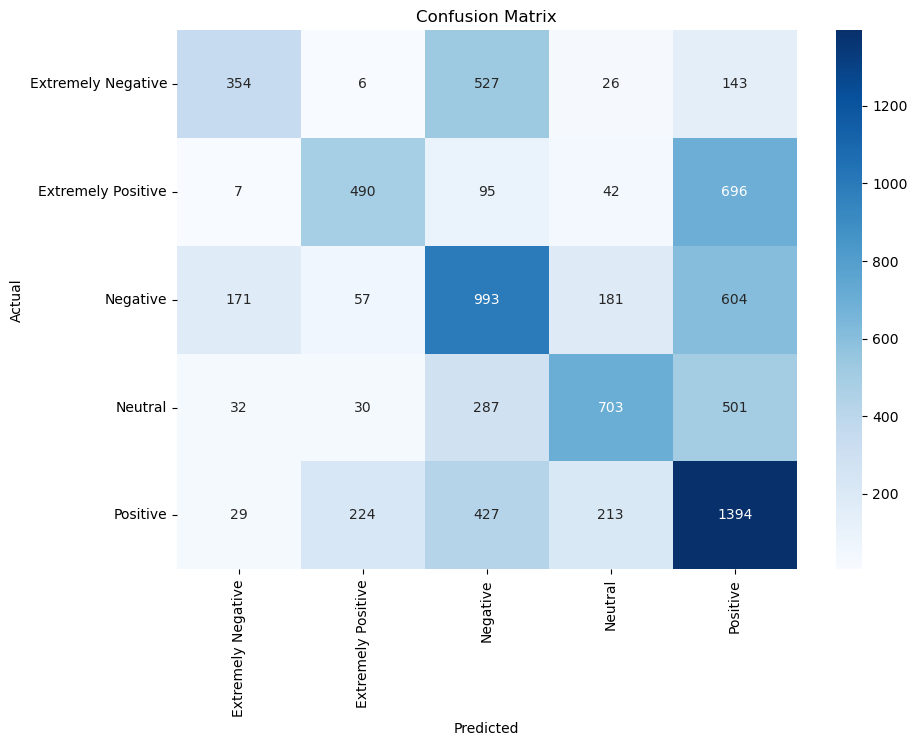

Accuracy: 0.477891156462585
F1 Score: 0.47609578664353447


In [14]:
# Evaluate the model
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred, average="weighted")  # Weighted average for multi-class
print("F1 Score:", f1)

__7. Try Logistic Regression Model__

In [16]:
# Model Pipeline and GridSearch
text_clf_log = Pipeline([
    ("vect", bow_vectorizer),
    ("tfidf", tfidf_transformer),
    ("clf", LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])


In [17]:
# Hyperparameter tuning for CountVectorizer, TfidfTransformer, and Naive Bayes
tuned_parameters_log = {
    "vect__ngram_range": [(1, 1), (1, 2), (2, 2)],  # unigrams, bigrams
    "tfidf__use_idf": [True, False],  # Whether to use IDF (Inverse Document Frequency)
    "tfidf__norm": ["l1", "l2"],  # Normalization methods for TF-IDF
    "clf__C": [1, 0.1, 0.01, 0.5]  # smoothing parameter
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(text_clf_log, tuned_parameters_log, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring="accuracy", n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and best accuracy score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'clf__C': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Best Accuracy: 0.5432953682611996


In [18]:
# Use the best model to predict on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.54      0.67      0.60      1056
Extremely Positive       0.58      0.70      0.64      1330
          Negative       0.53      0.41      0.46      2006
           Neutral       0.56      0.74      0.64      1553
          Positive       0.56      0.42      0.48      2287

          accuracy                           0.55      8232
         macro avg       0.55      0.59      0.56      8232
      weighted avg       0.55      0.55      0.54      8232



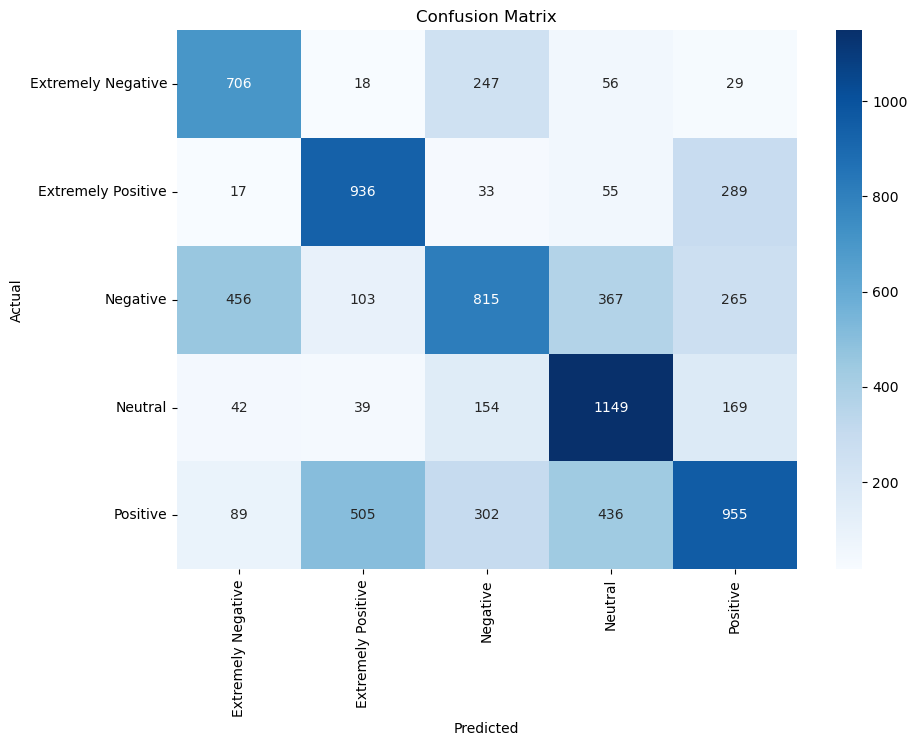

Accuracy: 0.5540573372206026
F1 Score: 0.5441625261943556


In [19]:
# Evaluate the model
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred, average="weighted")  # Weighted average for multi-class
print("F1 Score:", f1)